These are the quaternions of the rotation of the camera respected to the ego car. 
You can use the pyquaternion library to convert it to yaw_pitch_roll.

[1.28400265 0.31639086 1.67877024]
[ 1.50612211 -0.03602647  1.69421848]
[ 1.27320628 -0.31664681  1.68114556]
[1.04338732 0.31565584 1.66400371]
[ 0.81558292 -0.00559198  1.65395645]
[ 1.04116266 -0.31121292  1.66718288]

The original image size is 1224 * 1024.

These are the translation the cameras respected to the ego car

[1.28400265 0.31639086 1.67877024]
[ 1.50612211 -0.03602647  1.69421848]
[ 1.27320628 -0.31664681  1.68114556]
[1.04338732 0.31565584 1.66400371]
[ 0.81558292 -0.00559198  1.65395645]
[ 1.04116266 -0.31121292  1.66718288]

In [174]:
! pip install kornia

     |████████████████████████████████| 163kB 818kB/s eta 0:00:01
     |████████████████████████████████| 80.5MB 250kB/s eta 0:00:015    |██████▋                         | 16.5MB 2.8MB/s eta 0:00:23��  | 75.7MB 4.1MB/s eta 0:00:02
  Using cached https://files.pythonhosted.org/packages/45/0b/38b06fd9b92dc2b68d58b75f900e97884c45bedd2ff83203d933cf5851c9/future-0.18.2.tar.gz
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491057 sha256=657786df26b0f92d6ac9962a048b85db9c59666652e09befb19db01906bad362
  Stored in directory: /Users/mintielaptop/Library/Caches/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.5.0 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0


In [192]:
!pip install pyquaternion

In [255]:
import numpy as np
import pandas as pd
import math

from PIL import Image
import torchvision.transforms as T
import torch
import kornia
from pyquaternion import Quaternion


import matplotlib
import matplotlib.pyplot as plt

In [3]:
#local image path, will need to change for your notebook
PATH = "/Users/mintielaptop/Dropbox/NYU_Data_Science/Deep Learning/project/scene_106_sample_0/"

In [4]:
#in this case the matrix is transpose of the typical structure


intrinsics_big = {
    'CAM_FRONT_LEFT': 
              np.array([[879.03824732, 0.0,          613.17597314],
                [0.0,         879.03824732, 524.14407205],
                [0.0,         0.0,          4.0]]),
'CAM_FRONT': 
              np.array([[882.61644117, 0.0, 621.63358525],
                [0.0, 882.61644117, 524.38397862],
                [0.0, 0.0, 4.0]]),
'CAM_FRONT_RIGHT': 
    np.array([[880.41134027, 0.0, 618.9494972],
    [0.0, 880.41134027, 521.38918482],
    [0.0, 0.0, 4.0]]),
    
'CAM_BACK_LEFT': 
        np.array([[881.28264688, 0.0, 612.29732111],
    [0.0, 881.28264688, 521.77447199],
    [0.0, 0.0, 4.0]]),
'CAM_BACK': 
    np.array([[882.93018422, 0.0, 616.45479905],
    [0.0, 882.93018422, 528.27123027],
    [0.0, 0.0, 4.0]]),
'CAM_BACK_RIGHT': 
    np.array([[881.63835671, 0.0, 607.66308183],
    [0.0, 881.63835671, 525.6185326],
    [0.0, 0.0, 4.0]])}

In [5]:
image_names = [
    'CAM_FRONT_LEFT',
    'CAM_FRONT',
    'CAM_FRONT_RIGHT',
    'CAM_BACK_LEFT',
    'CAM_BACK',
    'CAM_BACK_RIGHT'
]

In [6]:
#need to scale all intrinsic values down by a factor of 4 beause Jason shrink the image
intrinsics = {}
for cam in image_names:
    intrinsics[cam] = intrinsics_big[cam]/4


In [7]:
intrinsics

{'CAM_FRONT_LEFT': array([[219.75956183,   0.        , 153.29399328],
        [  0.        , 219.75956183, 131.03601801],
        [  0.        ,   0.        ,   1.        ]]),
 'CAM_FRONT': array([[220.65411029,   0.        , 155.40839631],
        [  0.        , 220.65411029, 131.09599465],
        [  0.        ,   0.        ,   1.        ]]),
 'CAM_FRONT_RIGHT': array([[220.10283507,   0.        , 154.7373743 ],
        [  0.        , 220.10283507, 130.3472962 ],
        [  0.        ,   0.        ,   1.        ]]),
 'CAM_BACK_LEFT': array([[220.32066172,   0.        , 153.07433028],
        [  0.        , 220.32066172, 130.443618  ],
        [  0.        ,   0.        ,   1.        ]]),
 'CAM_BACK': array([[220.73254606,   0.        , 154.11369976],
        [  0.        , 220.73254606, 132.06780757],
        [  0.        ,   0.        ,   1.        ]]),
 'CAM_BACK_RIGHT': array([[220.40958918,   0.        , 151.91577046],
        [  0.        , 220.40958918, 131.40463315],
        [

In [8]:
int(round(151.91577046))

152

In [9]:
#looks like all the princpal points are C_u = int(round(intrinsic[0][2])), C_v = int(round(intrinsic[1][2]))

In [10]:
quaternion = {
'CAM_FRONT_LEFT': 
np.array([ 0.68316462, -0.68338771,  0.17581486, -0.18799863]),
 'CAM_FRONT':   
np.array([ 0.50745829, -0.49812866,  0.49496606, -0.49934369]),
 'CAM_FRONT_RIGHT':   
np.array([-0.19470424,  0.17808752, -0.68312934,  0.68095909]),
'CAM_BACK_LEFT': 
np.array([-0.67797289,  0.6871698,   0.19201452, -0.1768143 ]),
'CAM_BACK':    
np.array([-0.49033062,  0.50741961,  0.50819262, -0.49379061]),
'CAM_BACK_RIGHT':    
np.array([-0.17126042,  0.1897148,   0.68851343, -0.6786766 ]) }

In [11]:
translation = {
    'CAM_FRONT_LEFT': 
    [1.28400265, 0.31639086, 1.67877024],
    'CAM_FRONT':  
[ 1.50612211, -0.03602647,  1.69421848],
    'CAM_FRONT_RIGHT': 
[ 1.27320628, -0.31664681,  1.68114556],
    'CAM_BACK_LEFT':
[1.04338732, 0.31565584, 1.66400371],
    'CAM_BACK':
[ 0.81558292, -0.00559198,  1.65395645],
    'CAM_BACK_RIGHT':
[ 1.04116266, -0.31121292,  1.66718288]
    

    
}

In [12]:
#referr to https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation 
#Quaternion-derived rotation matrix
#scipy implementation
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html
 
from scipy.spatial.transform import Rotation as Rot    
    

In [13]:
#check the angles of all cameras

In [197]:
r = Rot.from_quat(quaternion["CAM_FRONT"])
r.as_euler('zyx', degrees=True)

#so y in the front is 90 deg counter clock-wise 
#also  x for the front -130? I think its saying it's pointing 50 deg down from horizontal line 
#that means 0 is parallel to ground pointing back, 
 

array([  39.3028511 ,   88.98297443, -129.58659387])

In [199]:
r.as_matrix()

array([[ 0.01373473, -0.01124289,  0.99984246],
       [-0.99989379, -0.00502913,  0.01367888],
       [ 0.00487454, -0.99992415, -0.01131076]])

In [200]:
ang_ax = kornia.quaternion_to_angle_axis(torch.tensor(quaternion["CAM_FRONT"]))

In [201]:
kornia.rad2deg(kornia.pi *ang_ax)

tensor([-216.1405,  214.7682, -216.6677], dtype=torch.float64)

In [205]:
ang_ax.unsqueeze(0)

tensor([[-1.2008,  1.1932, -1.2037]], dtype=torch.float64)

In [206]:
kornia.angle_axis_to_rotation_matrix(ang_ax.unsqueeze(0))

tensor([[[ 0.0113,  0.0137,  0.9998],
         [-0.9999,  0.0050,  0.0112],
         [-0.0049, -0.9999,  0.0137]]], dtype=torch.float64)

In [194]:
#try it with pyquartion library
#q6 = Quaternion(numpy.array([a, b, c, d]))
qfront = Quaternion(quaternion["CAM_FRONT"])
print(qfront.axis)
print(qfront.degrees)

[-0.57809971  0.57442938 -0.57950981]
119.01002803908763


In [195]:
qfront.rotation_matrix  

array([[ 0.01131076,  0.01367888,  0.99984246],
       [-0.99992415,  0.00502913,  0.01124289],
       [-0.00487454, -0.99989379,  0.01373473]])

In [15]:
r = Rot.from_quat(quaternion["CAM_BACK"])
r.as_euler('zyx', degrees=True)

#so y in the back is -90 deg counter clock-wise 
#x here means back camera means 0 is point to sky!, 
## using FRONT camera's 0 is parallel to ground as a reference, change to 8 deg  ##

array([-172.2672411 ,  -88.17938321,  -82.42121414])

In [187]:
rads = kornia.quaternion_to_angle_axis(torch.tensor(quaternion["CAM_BACK"]))
kornia.rad2deg(kornia.pi *rads)

tensor([-221.8228, -222.1608,  215.8648], dtype=torch.float64)

In [196]:
qback = Quaternion(quaternion["CAM_BACK"])
print(qback.axis)
print(qback.degrees)

[ 0.58221741  0.58310436 -0.56657938]
-121.27497379474417


In [16]:
r = Rot.from_quat(quaternion["CAM_FRONT_LEFT"])
r.as_euler('zyx', degrees=True)

#so y in here is  30 deg counter clock-wise 
#here x is assuming 0 is pointing parallel to the ground back keep

array([  89.72741595,   29.81356202, -178.90579948])

In [188]:
rads = kornia.quaternion_to_angle_axis(torch.tensor(quaternion["CAM_FRONT_LEFT"]))
kornia.rad2deg(kornia.pi *rads)

tensor([-275.8171,   70.9593,  -75.8767], dtype=torch.float64)

In [17]:
r = Rot.from_quat(quaternion["CAM_FRONT_RIGHT"])
r.as_euler('zyx', degrees=True)

#so y in the back should be 150 deg! why is it positive ## change and works
#x here is 0 is pointing parallel to the ground directly to the 'right'

array([-89.78478597,  30.56789854,  -1.45464565])

In [191]:
rads = kornia.quaternion_to_angle_axis(torch.tensor(quaternion["CAM_FRONT_RIGHT"]))
kornia.rad2deg(kornia.pi *rads)

tensor([ -89.8631,  344.7074, -343.6123], dtype=torch.float64)

In [18]:
r = Rot.from_quat(quaternion["CAM_BACK_LEFT"])
r.as_euler('zyx', degrees=True)

#so y in here is  -30 deg counter clock-wise #but its giving me issues, try -150 deg

array([  91.20437685,  -30.22340848, -178.39888889])

In [189]:
rads = kornia.quaternion_to_angle_axis(torch.tensor(quaternion["CAM_BACK_LEFT"]))
kornia.rad2deg(kornia.pi *rads)

tensor([-277.9092,  -77.6556,   71.5083], dtype=torch.float64)

In [19]:
r = Rot.from_quat(quaternion["CAM_BACK_RIGHT"])
r.as_euler('zyx', degrees=True)

#so y in here should be -150 deg! counter clock-wise  ## change but kept original y

array([-91.32482602, -29.56118841,  -1.89623567])

In [20]:
#let's try correcting CAM_BACK_LEFT by change y from -30 to -150
r = Rot.from_euler('zyx', [  91.20437685,  -150, -178.39888889], degrees=True)
r.as_quat() 

array([-0.1907042 ,  0.17546586,  0.67831433, -0.68755604])

In [21]:
r.as_quat()

array([-0.1907042 ,  0.17546586,  0.67831433, -0.68755604])

In [22]:
 #let's try correcting CAM_FRONT_RIGHT
r = Rot.from_euler('zyx', [-89.78478597,  150,  -1.45464565], degrees=True)
r.as_quat()

array([-0.6840013 ,  0.68192036, -0.19134027,  0.17468757])

In [23]:
r.as_matrix()

array([[-0.00325295, -0.86601929,  0.5       ],
       [-0.99971836, -0.00893775, -0.0219846 ],
       [ 0.02350796, -0.49993069, -0.86574631]])

In [24]:
#adjust quat
quaternion_adj = {
'CAM_FRONT_LEFT': 
np.array([ 0.68316462, -0.68338771,  0.17581486, -0.18799863]),
 'CAM_FRONT':   
np.array([ 0.50745829, -0.49812866,  0.49496606, -0.49934369]),
 'CAM_FRONT_RIGHT':   
#np.array([-0.19470424,  0.17808752, -0.68312934,  0.68095909]),
np.array([-0.6840013 ,  0.68192036, -0.19134027,  0.17468757]),
    
'CAM_BACK_LEFT': 
np.array([-0.67797289,  0.6871698,   0.19201452, -0.1768143 ]),
'CAM_BACK':    
np.array([-0.49033062,  0.50741961,  0.50819262, -0.49379061]),
'CAM_BACK_RIGHT':    
np.array([-0.17126042,  0.1897148,   0.68851343, -0.6786766 ]) #saw that we shuld keep it
    #np.array([ 0.6877757 , -0.67804142, -0.17392053,  0.19229162])
}

In [25]:
#adjust quat to angles - NOT CORRECT BECAUSE REFERNCE POINTS ARE DIFFERNT FROM FRONT , back , Left and Right
# format is zyx
#this adjusts all x axis assuming 0 is directly facing up. 
quaternion_adj2 = {
'CAM_FRONT_LEFT': 
np.array([ 0.68316462, -0.68338771,  0.17581486, -0.18799863]),
 'CAM_FRONT':   
np.array([ 0.50745829, -0.49812866,  0.49496606, -0.49934369]),
 'CAM_FRONT_RIGHT':   
#np.array([-0.19470424,  0.17808752, -0.68312934,  0.68095909]),
np.array([-0.6840013 ,  0.68192036, -0.19134027,  0.17468757]),
    
'CAM_BACK_LEFT': 
#np.array([-0.67797289,  0.6871698,   0.19201452, -0.1768143 ]),
np.array([-0.1907042 ,  0.17546586,  0.67831433, -0.68755604]),    
 
    
'CAM_BACK':    
np.array([-0.49033062,  0.50741961,  0.50819262, -0.49379061]),
'CAM_BACK_RIGHT':    
np.array([-0.17126042,  0.1897148,   0.68851343, -0.6786766 ]) 
#    np.array([ 0.6877757 , -0.67804142, -0.17392053,  0.19229162])
}

In [207]:
def gen_ex_matrix (quat, trans):
    assert len(quat) == 4
    #r = Rot.from_quat(quat)
    
    #m = r.as_matrix()
    #try using pyquarternion transform
    q_ = Quaternion(quat)
    m = q_.rotation_matrix  
    
    trans = np.expand_dims(trans, axis = 1)
    res = np.concatenate((m, trans), axis =1)
    
    return res
    

In [208]:
def gen_p_inv_matrix(int_matrix, ex_matrix):
    return np.linalg.pinv(int_matrix.dot(ex_matrix))

In [209]:
extrinsics = {}
inv_matrix = {}

for cam in image_names:
    extrinsics[cam] = gen_ex_matrix(quaternion[cam], translation[cam])
    inv_matrix[cam] = gen_p_inv_matrix(intrinsics[cam], extrinsics[cam])


In [210]:
inv_matrix

{'CAM_FRONT_LEFT': array([[ 2.91403544e-03, -2.51699710e-03, -3.97080953e-01],
        [ 1.81629547e-03,  4.07417066e-04, -8.31461161e-01],
        [ 1.29699951e-03,  3.71024498e-03, -9.58247537e-01],
        [ 1.04952829e-03,  2.58614075e-04,  1.06781371e-01]]),
 'CAM_FRONT': array([[ 1.45687469e-06, -4.53044489e-03,  5.76460494e-01],
        [ 1.92249606e-03, -2.17113827e-05, -8.34021834e-01],
        [ 2.83180741e-03,  9.16036123e-05, -8.60185322e-01],
        [ 1.11166588e-03, -2.65910693e-05,  1.06651616e-01]]),
 'CAM_FRONT_RIGHT': array([[-2.89467178e-03, -2.56290363e-03,  1.05377967e+00],
        [ 1.82579370e-03, -3.87783523e-04, -7.29931826e-01],
        [ 1.34542831e-03, -3.67187675e-03, -6.82327321e-03],
        [ 1.04272637e-03, -2.59326383e-04,  1.75495554e-01]]),
 'CAM_BACK_LEFT': array([[ 2.87991574e-03,  1.97123868e-03, -1.04619120e+00],
        [ 1.67678268e-03,  4.42585202e-04, -7.63422450e-01],
        [-2.01461330e-03,  4.00272268e-03, -1.36995337e-01],
        [ 9.

In [211]:
image_names

['CAM_FRONT_LEFT',
 'CAM_FRONT',
 'CAM_FRONT_RIGHT',
 'CAM_BACK_LEFT',
 'CAM_BACK',
 'CAM_BACK_RIGHT']

In [212]:
rot_matrix = {}

angles = [60, 0, 300, 120, 180, 240]
for i, cam in enumerate(image_names):
     
    rad = math.radians(angles[i])
    R = np.array([[math.cos(rad), -math.sin(rad)], [math.sin(rad), math.cos(rad)]])
    rot_matrix[cam] = R
# to convert camera to front camera axis do R.dot((Xw_cam, Zw_cam))

In [213]:
math.radians(180)

3.141592653589793

In [214]:
math.cos(math.radians(180))

-1.0

In [215]:
rot_matrix

{'CAM_FRONT_LEFT': array([[ 0.5      , -0.8660254],
        [ 0.8660254,  0.5      ]]),
 'CAM_FRONT': array([[ 1., -0.],
        [ 0.,  1.]]),
 'CAM_FRONT_RIGHT': array([[ 0.5      ,  0.8660254],
        [-0.8660254,  0.5      ]]),
 'CAM_BACK_LEFT': array([[-0.5      , -0.8660254],
        [ 0.8660254, -0.5      ]]),
 'CAM_BACK': array([[-1.0000000e+00, -1.2246468e-16],
        [ 1.2246468e-16, -1.0000000e+00]]),
 'CAM_BACK_RIGHT': array([[-0.5      ,  0.8660254],
        [-0.8660254, -0.5      ]])}

In [216]:
R= rot_matrix["CAM_BACK"]
R.dot(np.array([1, 1]))

array([-1., -1.])

In [217]:
#emperically figure out s-value for each camera

s_val ={
    
    'CAM_FRONT_LEFT': 3.571428571428571 ,
 'CAM_FRONT': 3.745318352059925,
 'CAM_FRONT_RIGHT':  3.236245954692557,
 'CAM_BACK_LEFT': 3.1847133757961785 ,
 'CAM_BACK':  2.7027027027027026,
 'CAM_BACK_RIGHT':2.8490028490028494
    
}

In [218]:
cam = 'CAM_FRONT_LEFT'
C_u = int(round(intrinsics[cam][0][2])), 
C_v = int(round(intrinsics[cam][1][2]))
uu = np.array([300, 301, 302]) - C_u
vv = np.array([200, 201, 202]) - C_v
cam_u_v = np.array([uu,vv,[1,1,1]])/0.28
world_dim = inv_matrix[cam].dot(cam_u_v)
world_dim

array([[-0.50853765, -0.50711966, -0.50570166],
       [-1.91554982, -1.90760799, -1.89966616],
       [-1.82707752, -1.80919451, -1.79131149],
       [ 0.99609429,  1.00076622,  1.00543816]])

In [219]:
#can we get back
intrinsics[cam].dot(extrinsics[cam].dot(world_dim))

array([[525.        , 528.57142857, 532.14285714],
       [246.42857143, 250.        , 253.57142857],
       [  3.57142857,   3.57142857,   3.57142857]])

In [220]:
cam_u_v

array([[525.        , 528.57142857, 532.14285714],
       [246.42857143, 250.        , 253.57142857],
       [  3.57142857,   3.57142857,   3.57142857]])

In [221]:
#okay it works

In [222]:
1/0.28

3.571428571428571

In [223]:
cam = 'CAM_FRONT'
C_u = int(round(intrinsics[cam][0][2])), 
C_v = int(round(intrinsics[cam][1][2]))
uu = np.array([300, 301, 302]) - C_u
vv = np.array([200, 201, 202]) - C_v
cam_u_v = np.array([uu,vv,[1,1,1]])/0.267
world_dim = inv_matrix[cam].dot(cam_u_v)
world_dim

array([[ 0.98903013,  0.97206763,  0.95510512],
       [-2.08523592, -2.07811688, -2.07099783],
       [-1.66012209, -1.64917299, -1.63822388],
       [ 0.99628608,  1.00035003,  1.00441398]])

In [224]:
 1/0.267

3.745318352059925

In [225]:
cam = 'CAM_FRONT_RIGHT'
C_u = int(round(intrinsics[cam][0][2])), 
C_v = int(round(intrinsics[cam][1][2]))
uu = np.array([300, 301, 302]) - C_u
vv = np.array([200, 201, 202]) - C_v
cam_u_v = np.array([uu,vv,[1,1,1]])#/0.267
world_dim = inv_matrix[cam].dot(cam_u_v)
world_dim

array([[ 0.45464901,  0.44919144,  0.44373386],
       [-0.49233659, -0.49089858, -0.48946057],
       [-0.06876754, -0.07109399, -0.07342044],
       [ 0.30853803,  0.30932143,  0.31010483]])

In [226]:
1/0.309

3.236245954692557

In [227]:
cam = 'CAM_BACK_LEFT'
C_u = int(round(intrinsics[cam][0][2])), 
C_v = int(round(intrinsics[cam][1][2]))
uu = np.array([300, 301, 302]) - C_u
vv = np.array([200, 201, 202]) - C_v
cam_u_v = np.array([uu,vv,[1,1,1]])#/0.267
world_dim = inv_matrix[cam].dot(cam_u_v)
world_dim

array([[-0.48485688, -0.48000572, -0.47515457],
       [-0.48595443, -0.48383506, -0.4817157 ],
       [-0.15295291, -0.1509648 , -0.14897669],
       [ 0.31240168,  0.31364602,  0.31489037]])

In [228]:
1/.314

3.1847133757961785

In [229]:
cam = 'CAM_BACK'
C_u = int(round(intrinsics[cam][0][2])), 
C_v = int(round(intrinsics[cam][1][2]))
uu = np.array([300, 301, 302]) - C_u
vv = np.array([200, 201, 202]) - C_v
cam_u_v = np.array([uu,vv,[1,1,1]])#/0.267
world_dim = inv_matrix[cam].dot(cam_u_v)
world_dim

array([[-0.28783638, -0.28331374, -0.2787911 ],
       [-0.39874233, -0.39725451, -0.39576668],
       [ 0.32683914,  0.32301482,  0.31919049],
       [ 0.36938924,  0.37022308,  0.37105692]])

In [230]:
1/0.370

2.7027027027027026

In [233]:
cam = 'CAM_BACK_RIGHT'
C_u = int(round(intrinsics[cam][0][2])), 
C_v = int(round(intrinsics[cam][1][2]))
uu = np.array([300, 301, 302]) - C_u
vv = np.array([200, 201, 202]) - C_v
cam_u_v = np.array([uu,vv,[1,1,1]])/0.351
world_dim = inv_matrix[cam].dot(cam_u_v)
world_dim

array([[ 0.6762197 ,  0.67344694,  0.67067419],
       [-1.22012801, -1.2165514 , -1.21297479],
       [ 0.94500345,  0.92791209,  0.91082073],
       [ 0.99753544,  0.99943757,  1.0013397 ]])

In [232]:
1/0.351

2.8490028490028494

In [52]:
#refer to this image https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#void
#translate u, v ( col idx, row idx) in camera image to Xw, Yw, Zw in real world, and take Zw, Xw (col idx, row idx in BEV)
# for each camera, need to rotate Zw, Xw to CAM FRONT Xw, Zw so it's all in the same canonical 
# stitch together, resize if necessary



In [53]:
#mapping
##each image size 256 (v, nrow), 306 (u, ncol)


In [234]:
def gen_cam_UV_m (cam, intrinsics, s_val):
    C_u = int(round(intrinsics[cam][0][2]))
    C_v = int(round(intrinsics[cam][1][2]))
    uu  = np.array(range(306)) - C_u
    vv = np.array(range(256)) - C_v
    #create all paris
    output = [[u, v, 1] for u in uu  
          for v in vv]
    
    result = np.array(output).T
    #result = result*s_val[cam]
    return result
    
 

In [235]:
test_res = gen_cam_UV_m('CAM_FRONT_LEFT', intrinsics, s_val)

In [236]:
test_res.shape

(3, 78336)

In [237]:
def gen_world_dim (cam, cam_uv_m, inv_matrix):
    world_dim = inv_matrix[cam].dot(cam_uv_m)
    return world_dim

In [238]:
test_wdim = gen_world_dim('CAM_FRONT_LEFT', test_res, inv_matrix)

In [239]:
test_wdim #definitely some distortion there seeing the fourth row are not 1's 

array([[-0.51320175, -0.51571875, -0.51823575, ..., -0.26122121,
        -0.26373821, -0.26625521],
       [-1.162726  , -1.16231859, -1.16191117, ..., -0.50567937,
        -0.50527195, -0.50486453],
       [-1.64273055, -1.63902031, -1.63531006, ..., -0.30845372,
        -0.30474348, -0.30103323],
       [-0.0876749 , -0.08741629, -0.08715767, ...,  0.29786059,
         0.2981192 ,  0.29837782]])

In [240]:
test_wdim.shape

(4, 78336)

In [241]:
print(min(test_wdim[0]))

-1.1550360161505329


In [242]:
print(max(test_wdim[0]))

0.37557905520357965


In [243]:
print(min(test_wdim[2]))

-1.6427305544801867


In [244]:
print(max(test_wdim[2]))

-0.3010332348585366


In [245]:
test_wdim[0].shape

(78336,)

In [246]:
np.stack((test_wdim[0], test_wdim[2]), axis=0)

array([[-0.51320175, -0.51571875, -0.51823575, ..., -0.26122121,
        -0.26373821, -0.26625521],
       [-1.64273055, -1.63902031, -1.63531006, ..., -0.30845372,
        -0.30474348, -0.30103323]])

In [247]:
def gen_BEV_XZ (cam, wdim, rot_matrix, axis = "XZ" ):
    
    R = rot_matrix[cam]
    if axis == "XZ":
        cam_XZ = np.stack((wdim[0], wdim[2]), axis=0)
    elif axis == "XY":
        cam_XZ = np.stack((wdim[0], wdim[1]), axis=0) #try using the world Y axis
    
    else:
        print("axis must be XZ or XY")
    result = R.dot(cam_XZ)
    return result

In [248]:
bev_XZ = gen_BEV_XZ('CAM_FRONT_LEFT', test_wdim, rot_matrix)

In [249]:
bev_XZ

array([[ 1.16604551,  1.16157385,  1.15710218, ...,  0.13651816,
         0.13204649,  0.12757483],
       [-1.26581103, -1.2661357 , -1.26646036, ..., -0.38045107,
        -0.38077573, -0.38110039]])

In [250]:
print(min(bev_XZ[0]))

0.025770950248058498


In [251]:
print(max(bev_XZ[0]))

1.267849389802103


In [252]:
print(min(bev_XZ[1]))

-1.3485995747594353


In [253]:
print(max(bev_XZ[1]))

-0.2983118492466031


In [77]:
##put it all together
# allCam_map_dict ={}
# min_max_dict = {}
# color_list = ['b', 'g', 'r', 'c', 'm', 'k']
 
# for j, cam in enumerate(image_names):
    

#     #allCam_map_dict[cam] = {}
#     map_dict = {} 
#     col_ind  = np.arange(306)
#     row_ind = np.arange(256)
#     all_cam_row_col = [(r,c) for r in row_ind for c in col_ind]
#     row_col_ind_dict = {}
#     for i, pair in enumerate(all_cam_row_col):
#         row_col_ind_dict[pair] = i #use later to map from cam image (row, col) to BEV (row, col)
        
        
#     #generate camera X_w, Y_w, Z_w
#     test_res = gen_cam_UV_m(cam, intrinsics, s_val)
#     test_wdim = gen_world_dim(cam, test_res, inv_matrix)
    
#     #rotate Z_w, X_w into BEV Z_w, X_w
#     bev_XZ = gen_BEV_XZ(cam, test_wdim, rot_matrix)
#     print(bev_XZ.shape)
#     #create the mapping 
#     bev_X = bev_XZ[0]
#     bev_Z = bev_XZ[1]
#     for pair, ind in row_col_ind_dict.items():
    
#         map_dict[pair] = (bev_X[ind], bev_Z[ind]) 
#     allCam_map_dict[cam] = map_dict
#     min_max_dict[cam] = [min(bev_X), max(bev_X), min(bev_Z), max(bev_Z)] 
    
#     #plotting
#     plt.scatter(bev_Z*3000, bev_X*3000, color = color_list[j])
    
    

In [78]:
# import pickle


# f = open("allCam_map_dict.pkl","wb")
# pickle.dump(allCam_map_dict,f)
# f.close()

# f = open("min_max_dict.pkl","wb")
# pickle.dump(min_max_dict,f)

# f.close()


In [256]:
col_ind  = np.arange(306)
row_ind = np.arange(256)
all_cam_row_col = [(r,c) for r in row_ind for c in col_ind]

In [257]:
#try it with the correct right camera Y angles
#intrinsics is given
#translation is given

# extrinsics_adj crateded with quaternion_adj
#inv_matrix recreated 
def gen_trans_maps(image_names, intrinsics, translation, quaternion, all_cam_row_col, axis = "XZ"):
    
    extrinsics_adj = {}
    inv_matrix_adj = {}

    for cam in image_names:

        extrinsics_adj[cam] = gen_ex_matrix(quaternion[cam], translation[cam]) #use quaternion_adj2
        inv_matrix_adj[cam] = gen_p_inv_matrix(intrinsics[cam], extrinsics_adj[cam])


    ##put it all together
    allCam_map_dict ={}
    min_max_dict = {}
    color_list = ['b', 'g', 'r', 'c', 'm', 'k']

    for j, cam in enumerate(image_names):

        #allCam_map_dict[cam] = {}
        map_dict = {} 
        
        row_col_ind_dict = {}
        for i, pair in enumerate(all_cam_row_col):
            row_col_ind_dict[pair] = i #use later to map from cam image (row, col) to BEV (row, col)




        #generate camera X_w, Y_w, Z_w
        test_res = gen_cam_UV_m(cam, intrinsics, s_val)
        test_wdim = gen_world_dim(cam, test_res, inv_matrix_adj)

        #rotate Z_w, X_w into BEV Z_w, X_w
        bev_XZ = gen_BEV_XZ(cam, test_wdim, rot_matrix, axis = axis) #try XY sometimes
        print(bev_XZ.shape)
        #create the mapping 
        bev_X = bev_XZ[0]*200
        bev_Z = bev_XZ[1]*200
        for pair, ind in row_col_ind_dict.items():

            map_dict[pair] = (bev_X[ind], bev_Z[ind]) 
        allCam_map_dict[cam] = map_dict
        min_max_dict[cam] = [min(bev_X), max(bev_X), min(bev_Z), max(bev_Z)] 

        #plotting
        plt.scatter(bev_Z, bev_X, color = color_list[j])
        
    return allCam_map_dict, min_max_dict

(2, 78336)
(2, 78336)
(2, 78336)
(2, 78336)
(2, 78336)
(2, 78336)


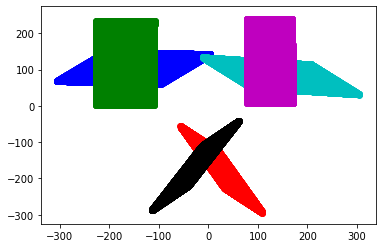

In [284]:
allCam_map_dict, min_max_dict = gen_trans_maps(image_names, intrinsics, translation, 
                                               quaternion_adj2,all_cam_row_col, axis = "XY")

In [285]:
min_max_dict

{'CAM_FRONT_LEFT': [60.81958167452044,
  150.06987586074553,
  -305.9415716286822,
  4.176612061661742],
 'CAM_FRONT': [2.89190256713745,
  234.03346111561189,
  -226.94018699017647,
  -108.56064681958546],
 'CAM_FRONT_RIGHT': [-294.03546888744955,
  -56.24624321458421,
  -56.20515342223334,
  108.9908403595116],
 'CAM_BACK_LEFT': [31.327775738185714,
  134.11570176071297,
  -11.235503316455578,
  303.8917423276606],
 'CAM_BACK': [7.2789718796834695,
  238.78425140044035,
  77.38987676031189,
  170.52595567857273],
 'CAM_BACK_RIGHT': [-287.5835235636826,
  -41.340534941547446,
  -114.29653585664548,
  61.46925725232536]}

In [286]:
## okay how to piece them together
#first let's check image


In [287]:
allCam_map_dict["CAM_FRONT"]

{(0, 0): (233.94459175950928, -225.83290647472288),
 (0, 1): (233.0385027822843, -225.8372487512541),
 (0, 2): (232.1324138050593, -225.84159102778526),
 (0, 3): (231.22632482783433, -225.84593330431647),
 (0, 4): (230.3202358506093, -225.85027558084764),
 (0, 5): (229.41414687338434, -225.85461785737886),
 (0, 6): (228.50805789615936, -225.85896013391),
 (0, 7): (227.60196891893435, -225.86330241044124),
 (0, 8): (226.69587994170936, -225.86764468697243),
 (0, 9): (225.78979096448438, -225.87198696350362),
 (0, 10): (224.88370198725943, -225.8763292400348),
 (0, 11): (223.9776130100344, -225.880671516566),
 (0, 12): (223.07152403280944, -225.8850137930972),
 (0, 13): (222.16543505558442, -225.88935606962838),
 (0, 14): (221.25934607835944, -225.89369834615957),
 (0, 15): (220.3532571011345, -225.89804062269076),
 (0, 16): (219.44716812390945, -225.90238289922192),
 (0, 17): (218.5410791466845, -225.9067251757531),
 (0, 18): (217.6349901694595, -225.9110674522843),
 (0, 19): (216.72890

In [288]:
#cam = "CAM_BACK_RIGHT"
def convert_show_img(cam, min_max_dict, allCam_map_dict, all_cam_row_col, PATH):
    img = Image.open(PATH+cam+".jpeg")
    t = T.ToTensor()
    m = t(img)
    print(m.shape)
    print("orig image mean{}".format( m.mean()))
    row_min = min_max_dict[cam][0]
    row_max = min_max_dict[cam][1]
    col_min = min_max_dict[cam][2] 
    col_max = min_max_dict[cam][3]#adjusting
    img_list = []

    ind_map = allCam_map_dict[cam]
    for i in [0,1,2]:
        channel_i  = m[i]
        avg_val = channel_i.mean()
        base_tensor = torch.ones((int(row_max-row_min+4), 
                                  int(col_max-col_min+4)))*avg_val #initialize with average val

        for pair in all_cam_row_col:
            new_row, new_col = ind_map[pair]
            new_row = int(round(new_row - row_min))
            new_col = int(round(new_col - col_min))

            base_tensor[new_row, new_col] = channel_i[pair[0], pair[1]]
        img_list.append(base_tensor)
        
    trans_tensor = torch.stack(img_list, dim=0)
    print(trans_tensor.shape)
    print(trans_tensor.mean())    
    
    toImg = T.ToPILImage()
    trans_img = toImg(trans_tensor)
    toResize = T.Resize((400,400))
    trans_img = toResize(trans_img)
    return trans_img

In [289]:
#generate all transformations and print picture
PATH = "/Users/mintielaptop/Dropbox/NYU_Data_Science/Deep Learning/project/scene_106_sample_0/"
trans_list = []
 

for cam in image_names:
    trans_img = convert_show_img(cam, min_max_dict, allCam_map_dict,all_cam_row_col, PATH)
    trans_list.append(trans_img)

torch.Size([3, 256, 306])
orig image mean0.4158973693847656
torch.Size([3, 93, 314])
tensor(0.4185)
torch.Size([3, 256, 306])
orig image mean0.4889695942401886
torch.Size([3, 235, 122])
tensor(0.4890)
torch.Size([3, 256, 306])
orig image mean0.5456956624984741
torch.Size([3, 241, 169])
tensor(0.5470)
torch.Size([3, 256, 306])
orig image mean0.41098126769065857
torch.Size([3, 106, 319])
tensor(0.4127)
torch.Size([3, 256, 306])
orig image mean0.4967092275619507
torch.Size([3, 235, 97])
tensor(0.4946)
torch.Size([3, 256, 306])
orig image mean0.47694629430770874
torch.Size([3, 250, 179])
tensor(0.4781)


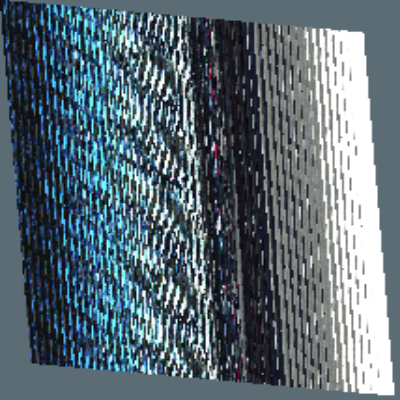

In [266]:
trans_list[0]

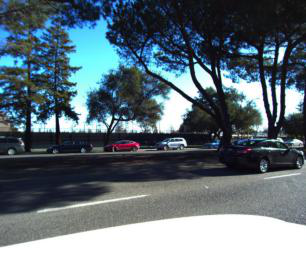

In [267]:
pic = Image.open(PATH+image_names[0]+".jpeg")
pic

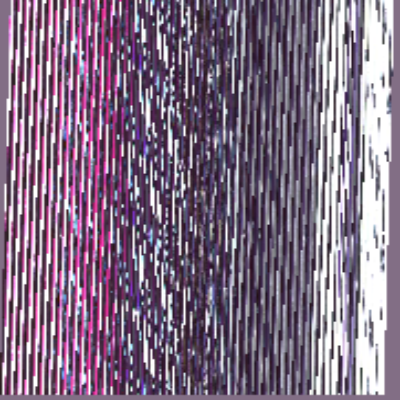

In [268]:
trans_list[1]

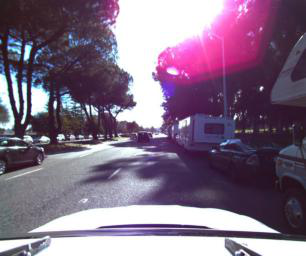

In [269]:
pic = Image.open(PATH+image_names[1]+".jpeg")
pic

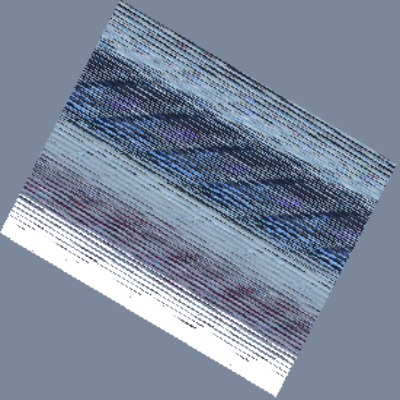

In [270]:
trans_list[2]

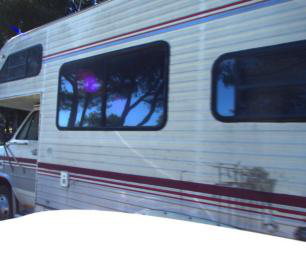

In [271]:
pic = Image.open(PATH+image_names[2]+".jpeg")
pic

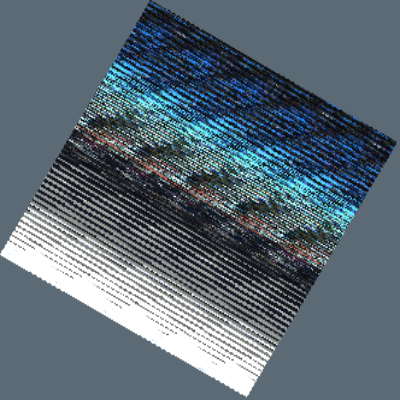

In [272]:
trans_list[3]

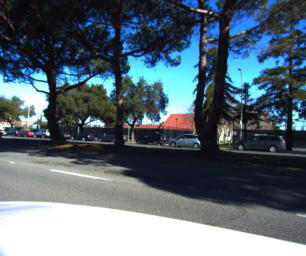

In [273]:
pic = Image.open(PATH+image_names[3]+".jpeg")
pic

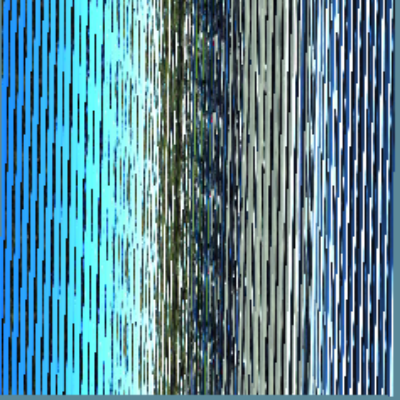

In [274]:
trans_list[4]

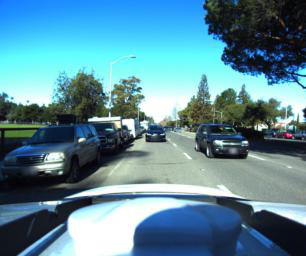

In [275]:
pic = Image.open(PATH+image_names[4]+".jpeg")
pic

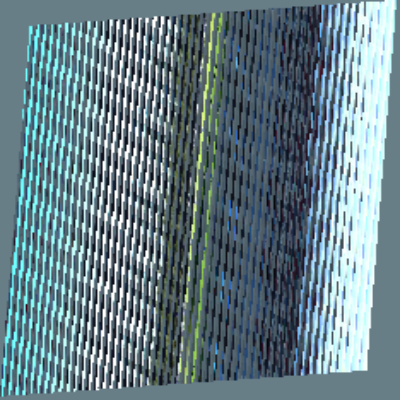

In [276]:
trans_list[5]

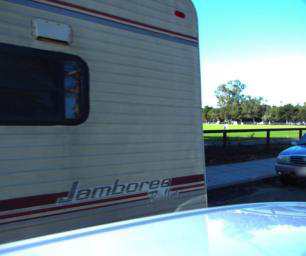

In [277]:
pic = Image.open(PATH+image_names[5]+".jpeg")
pic

In [278]:
import matplotlib.pyplot as plt

In [295]:
import cv2

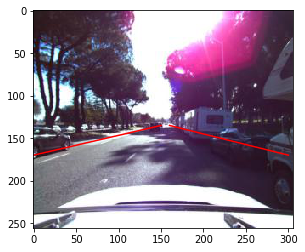

In [302]:
img = plt.imread(PATH+image_names[1]+".jpeg")
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(img)

ax.plot(np.linspace(0, 150, 10), np.linspace(170,135, 10), color = 'r')
ax.plot(np.linspace(160, 300, 10), np.linspace(135,170, 10), color = 'r')
plt.show()

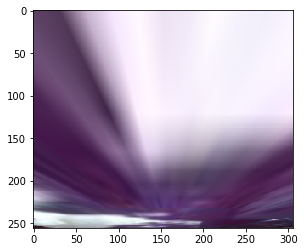

In [303]:
h = img.shape[0]
w = img.shape[1]

src = np.float32([[0, 170], [150, 135], [160, 135], [300, 170]])
dst = np.float32([[0, 256], [0, 0], [306, 0], [306, 256]])
M_ = cv2.getPerspectiveTransform(src, dst)

 
img_bev = cv2.warpPerspective(img, M_, (w, h)) #, flags=INTER_MODE[resample],
                              #borderMode=cv2.BORDER_CONSTANT, borderValue=fillcolor)
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(img_bev)

In [280]:
img.shape

(256, 306, 3)

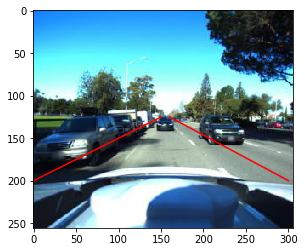

In [283]:
img = plt.imread(PATH+image_names[4]+".jpeg")
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(img)

ax.plot(np.linspace(0, 150, 10), np.linspace(200,125, 10), color = 'r')
ax.plot(np.linspace(160, 300, 10), np.linspace(125,200, 10), color = 'r')
plt.show()

In [290]:
img.shape

(256, 306, 3)

In [293]:
#!pip install opencv-python

     |████████████████████████████████| 49.1MB 3.9MB/s eta 0:00:01


In [297]:
h = img.shape[0]
w = img.shape[1]

src = np.float32([[0, 200], [150, 125], [160, 125], [300, 200]])
dst = np.float32([[0, 256], [0, 0], [306, 0], [306, 256]])
M_ = cv2.getPerspectiveTransform(src, dst)

 
img_bev = cv2.warpPerspective(img, M_, (w, h)) #, flags=INTER_MODE[resample],
                              #borderMode=cv2.BORDER_CONSTANT, borderValue=fillcolor)

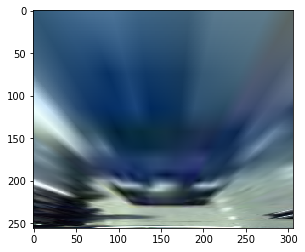

In [300]:
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(img_bev)